# Building a Predictive Model for COVID-19 ICU Admission

Accurate predictions are always desirable, but it is especially important for medical applications. A false negative would not just be a statistical inconvenience, it could very well lead to more severe illness or death.

Now, we aren't exactly attempting to diagnose here, but I'm aiming to at least get a reasonably high recall of positive ICU admission. I'll start by doing a basic logistic regression.

In [1]:

import numpy as np 
import pandas as pd 
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import seaborn as sns
sns.set(style="whitegrid")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/covid19/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx


In [2]:
df = pd.read_excel("../input/covid19/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx")

df.shape

(1925, 231)

In [3]:
df.dtypes

PATIENT_VISIT_IDENTIFIER        int64
AGE_ABOVE65                     int64
AGE_PERCENTIL                  object
GENDER                          int64
DISEASE GROUPING 1            float64
                               ...   
RESPIRATORY_RATE_DIFF_REL     float64
TEMPERATURE_DIFF_REL          float64
OXYGEN_SATURATION_DIFF_REL    float64
WINDOW                         object
ICU                             int64
Length: 231, dtype: object

In [4]:
df.select_dtypes(include=['object']).head()

,AGE_PERCENTIL,WINDOW
0,60th,0-2
1,60th,2-4
2,60th,4-6
3,60th,6-12
4,60th,ABOVE_12


In [5]:
print(df.select_dtypes(include=['object']).isnull().sum())

AGE_PERCENTIL    0
WINDOW           0
dtype: int64


These are the two non-numeric columns in the data set. As we can see, there are no missing pieces of data in this column, which is more than can be said for the rest of the data.

In [6]:
df.select_dtypes(exclude=['object']).isnull().sum()

PATIENT_VISIT_IDENTIFIER        0
AGE_ABOVE65                     0
GENDER                          0
DISEASE GROUPING 1              5
DISEASE GROUPING 2              5
                             ... 
HEART_RATE_DIFF_REL           685
RESPIRATORY_RATE_DIFF_REL     748
TEMPERATURE_DIFF_REL          694
OXYGEN_SATURATION_DIFF_REL    686
ICU                             0
Length: 229, dtype: int64

There are A LOT of missing values, around 50% of the numeric data. We'll use scikit-learn to fill the null values with imputed means. This is probably not the best approach. If we dropped incomplete columns:

In [7]:
df.dropna().shape

(545, 231)

We lose a huge portion of our data! I'd greatly appreciate any other solutions or suggestions, but for now impution will do for this cursory analysis

In [8]:
df_cat = df.select_dtypes(include=['object'])
df_numeric = df.select_dtypes(exclude=['object'])

imp = SimpleImputer(missing_values=np.nan, strategy='mean')

idf = pd.DataFrame(imp.fit_transform(df_numeric))
idf.columns = df_numeric.columns
idf.index = df_numeric.index


idf.isnull().sum()


PATIENT_VISIT_IDENTIFIER      0
AGE_ABOVE65                   0
GENDER                        0
DISEASE GROUPING 1            0
DISEASE GROUPING 2            0
                             ..
HEART_RATE_DIFF_REL           0
RESPIRATORY_RATE_DIFF_REL     0
TEMPERATURE_DIFF_REL          0
OXYGEN_SATURATION_DIFF_REL    0
ICU                           0
Length: 229, dtype: int64

Next, we'll identify the most important numerical features. We'll use the corr method to identify all the features with at least a weak correlation to the dependent variable (ICU Admission)

In [9]:
idf.drop(["PATIENT_VISIT_IDENTIFIER"],1)
idf = pd.concat([idf,df_cat ], axis=1)

cor = idf.corr()
cor_target = abs(cor["ICU"])
relevant_features = cor_target[cor_target>0.2]
relevant_features.index

Index(['AGE_ABOVE65', 'BE_ARTERIAL_MEDIAN', 'BE_ARTERIAL_MEAN',
       'BE_ARTERIAL_MIN', 'BE_ARTERIAL_MAX', 'BE_VENOUS_MEDIAN',
       'BE_VENOUS_MEAN', 'BE_VENOUS_MIN', 'BE_VENOUS_MAX', 'HEMOGLOBIN_MEDIAN',
       'HEMOGLOBIN_MEAN', 'HEMOGLOBIN_MIN', 'HEMOGLOBIN_MAX', 'LACTATE_MEDIAN',
       'LACTATE_MEAN', 'LACTATE_MIN', 'LACTATE_MAX', 'LEUKOCYTES_MEDIAN',
       'LEUKOCYTES_MEAN', 'LEUKOCYTES_MIN', 'LEUKOCYTES_MAX',
       'BLOODPRESSURE_DIASTOLIC_MEAN', 'RESPIRATORY_RATE_MEAN',
       'BLOODPRESSURE_DIASTOLIC_MEDIAN', 'RESPIRATORY_RATE_MEDIAN',
       'BLOODPRESSURE_DIASTOLIC_MIN', 'TEMPERATURE_MIN',
       'BLOODPRESSURE_SISTOLIC_MAX', 'HEART_RATE_MAX', 'RESPIRATORY_RATE_MAX',
       'OXYGEN_SATURATION_MAX', 'BLOODPRESSURE_DIASTOLIC_DIFF',
       'BLOODPRESSURE_SISTOLIC_DIFF', 'HEART_RATE_DIFF',
       'RESPIRATORY_RATE_DIFF', 'TEMPERATURE_DIFF', 'OXYGEN_SATURATION_DIFF',
       'BLOODPRESSURE_DIASTOLIC_DIFF_REL', 'BLOODPRESSURE_SISTOLIC_DIFF_REL',
       'HEART_RATE_DIFF_REL', 

These are all the features with a correlation coefficient over 0.2, indicating that each of these variables is at least weakly correlated to ICU Admission. Some of these features are clearly correlated with one another (included are the mean, median, max, and min for a single metric), so it may be a good idea to drop even more of these values. For now, though, let's just see what result we get with all of them. The dataframe we'll be analyzing going forward will consist of these features, plus the categorical WINDOW feature. I observed a positive correlation between WINDOW and ICU in some visual data exploration I conducted, which can be seen immediately below.

In [10]:
data = pd.concat([idf[relevant_features.index],idf["WINDOW"]],1)

data.ICU.value_counts()

0.0    1410
1.0     515
Name: ICU, dtype: int64

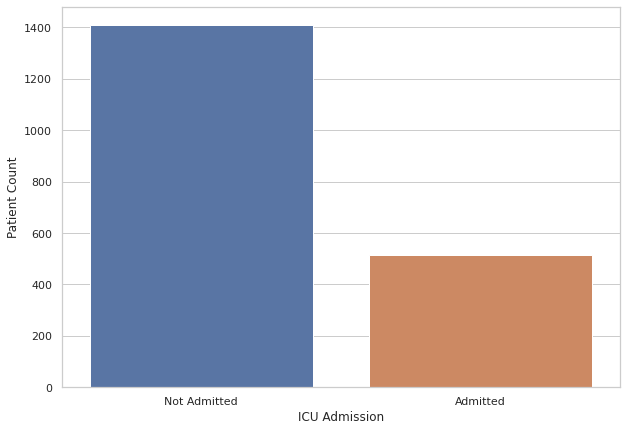

In [11]:
plt.figure(figsize=(10,7))
count = sns.countplot(x = "ICU",data=data)
count.set_xticklabels(["Not Admitted","Admitted"])
plt.xlabel("ICU Admission")
plt.ylabel("Patient Count")
plt.show()

Of all the patients, about 26.7% were admitted to the ICU

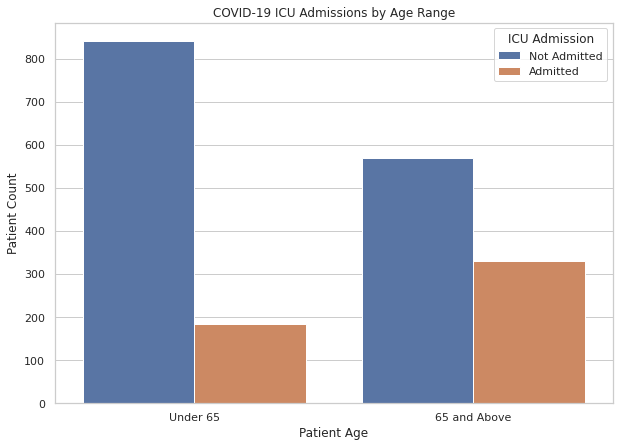

In [12]:
plt.figure(figsize=(10,7))
age = sns.countplot(data.AGE_ABOVE65, hue='ICU', data=data)
age.set_xticklabels(["Under 65","65 and Above"])
plt.title("COVID-19 ICU Admissions by Age Range")
plt.xlabel("Patient Age")
plt.ylabel("Patient Count")
plt.xticks(rotation = 0)
plt.legend(title = "ICU Admission",labels=['Not Admitted', 'Admitted'])
plt.show()

Individials above 65 appear to be admitted to the ICU more often than those below, corroroborating the statements of public health officials; older patients are at a higher risk for more serious illness

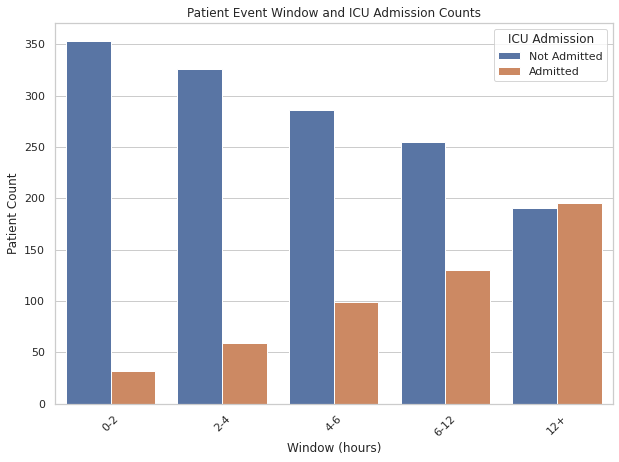

In [13]:
plt.figure(figsize=(10,7))
window = sns.countplot(data.WINDOW, hue='ICU', data=data)
window.set_xticklabels(["0-2","2-4","4-6","6-12","12+"])
plt.xticks(rotation = 45)
plt.title("Patient Event Window and ICU Admission Counts")
plt.ylabel("Patient Count")
plt.xlabel("Window (hours)")
plt.legend(title = "ICU Admission",labels=['Not Admitted', 'Admitted'])

There is a clear positive correlation between the Window and ICU Admission, hence it's inclusion in the model

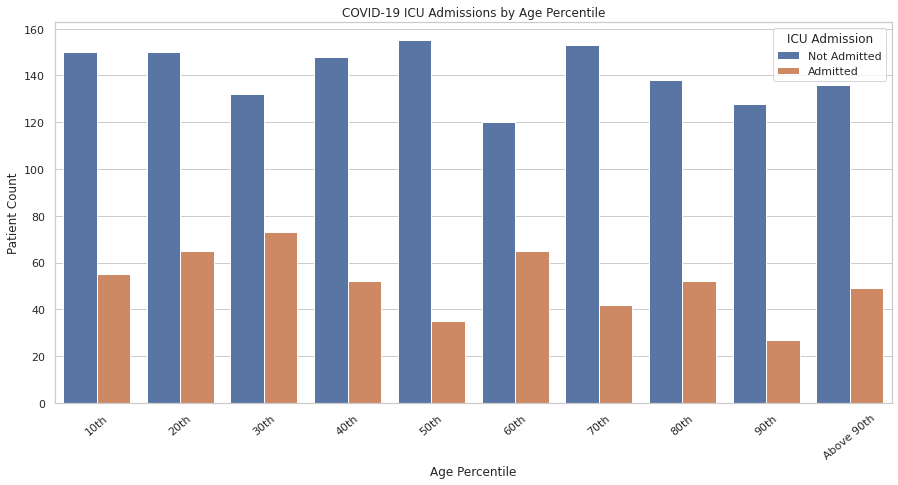

In [14]:
plt.figure(figsize=(15,7))
percentile = age = sns.countplot(sorted(idf.AGE_PERCENTIL), hue='ICU', data=idf)
plt.xticks(rotation=40)
plt.xlabel("Age Percentile")
plt.ylabel("Patient Count")
plt.title("COVID-19 ICU Admissions by Age Percentile")
plt.legend(title = "ICU Admission",labels=['Not Admitted', 'Admitted'], loc = 0)

In contrast, there doesn't seem to be a clear relation between age percentile and ICU admission.

Now, onto our logistic regression. We'll need to encode our categorical variable, WINDOW. We'll use get_dummies for this purpose. Also, we'll change AG_ABOVE65 and ICU back to int (they became floats during impution), just to make things look nicer.

In [15]:
data = pd.get_dummies(data)

data.AGE_ABOVE65 = data.AGE_ABOVE65.astype(int)
data.ICU = data.ICU.astype(int)

data.head()

,AGE_ABOVE65,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,HEMOGLOBIN_MEDIAN,...,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,ICU,WINDOW_0-2,WINDOW_2-4,WINDOW_4-6,WINDOW_6-12,WINDOW_ABOVE_12
0,1,-0.963433,-0.963433,-0.963433,-0.963433,-0.931121,-0.931121,-0.931121,-0.931121,-0.202472,...,-1.000000,-1.000000,-1.000000,-1.000000,0,1,0,0,0,0
1,1,-0.963433,-0.963433,-0.963433,-0.963433,-0.931121,-0.931121,-0.931121,-0.931121,-0.202472,...,-1.000000,-1.000000,-1.000000,-1.000000,0,0,1,0,0,0
2,1,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.109756,...,-0.817800,-0.719147,-0.771327,-0.886982,0,0,0,1,0,0
3,1,-0.963433,-0.963433,-0.963433,-0.963433,-0.931121,-0.931121,-0.931121,-0.931121,-0.202472,...,-0.817800,-0.719147,-1.000000,-1.000000,0,0,0,0,1,0
4,1,-0.871658,-0.871658,-0.871658,-0.871658,-0.863874,-0.863874,-0.863874,-0.863874,-0.353659,...,-0.230462,0.096774,-0.242282,-0.814433,1,0,0,0,0,1


Now, we create two dataframes, one being the dependent variable, ICU, and the other being all the independent variables. We'll then create a train-test split in order to evaluate the model later.

In [16]:
y = data.ICU
X = data.drop("ICU", 1)

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=42, shuffle = True)

Now for the logisitic regression. It's actually pretty easy. We'll use the logistic regression model to then predict y values in y_hat, which we'll compare to y_test (the actual values)

In [17]:
LR = LogisticRegression(max_iter = 500)
LR.fit(X_train,y_train)

y_hat = LR.predict(X_test)

              precision    recall  f1-score   support

           0       0.84      0.96      0.90       346
           1       0.85      0.54      0.66       136

    accuracy                           0.84       482
   macro avg       0.85      0.75      0.78       482
weighted avg       0.85      0.84      0.83       482

AUC =  0.7532726963617816


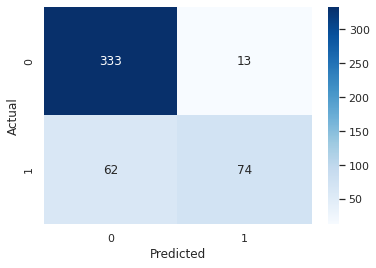

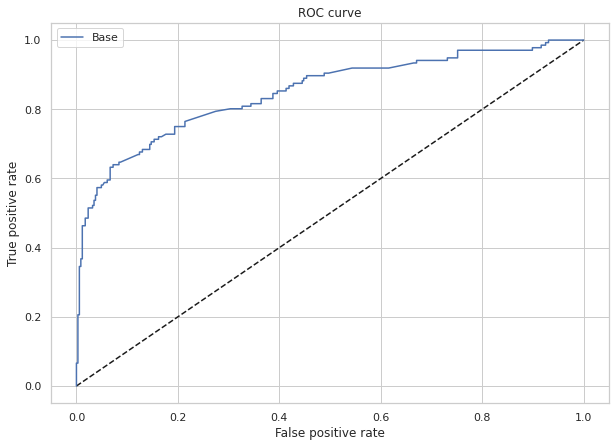

In [18]:
confusion_matrix = pd.crosstab(y_test, y_hat, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, fmt = 'g', cmap = 'Blues')

print(classification_report(y_test, y_hat))
print("AUC = ",roc_auc_score(y_test, y_hat))

yhat_probs = LR.predict_proba(X_test)
yhat_probs = yhat_probs[:, 1]
fpr, tpr, _ = roc_curve(y_test, yhat_probs)


plt.figure(figsize=(10,7))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label = "Base")
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc="best")
plt.show()

And so here's our Logistic Regression model. Kinda cool, but I'd like to try and improve the metrics for the minority case (positive ICU admission). Let's tune the regression a bit.

First, we'll try LabelEncoding WINDOW instead of using dummy variables

In [19]:
data2 = pd.concat([idf[relevant_features.index],idf["WINDOW"]],1)
data2.AGE_ABOVE65 = data2.AGE_ABOVE65.astype(int)
data2.ICU = data2.ICU.astype(int)

X2 = data2.drop("ICU",1)
y2 = data2.ICU

In [20]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

X2.WINDOW = label_encoder.fit_transform(np.array(X2["WINDOW"].astype(str)).reshape((-1,)))
X2.WINDOW

0       0
1       1
2       2
3       3
4       4
       ..
1920    0
1921    1
1922    2
1923    3
1924    4
Name: WINDOW, Length: 1925, dtype: int64

In [21]:
X2_train,X2_test,y2_train,y2_test = train_test_split(X2,y2,test_size=0.25,random_state=42, shuffle = True)

LR.fit(X2_train,y2_train)

y2_hat = LR.predict(X2_test)

ORIGINAL
              precision    recall  f1-score   support

           0       0.84      0.96      0.90       346
           1       0.85      0.54      0.66       136

    accuracy                           0.84       482
   macro avg       0.85      0.75      0.78       482
weighted avg       0.85      0.84      0.83       482

AUC =  0.7532726963617816 


LABEL ENCODING
              precision    recall  f1-score   support

           0       0.85      0.96      0.90       346
           1       0.84      0.56      0.67       136

    accuracy                           0.84       482
   macro avg       0.84      0.76      0.78       482
weighted avg       0.84      0.84      0.83       482

AUC =  0.7577354641278476


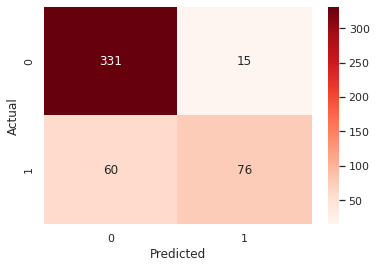

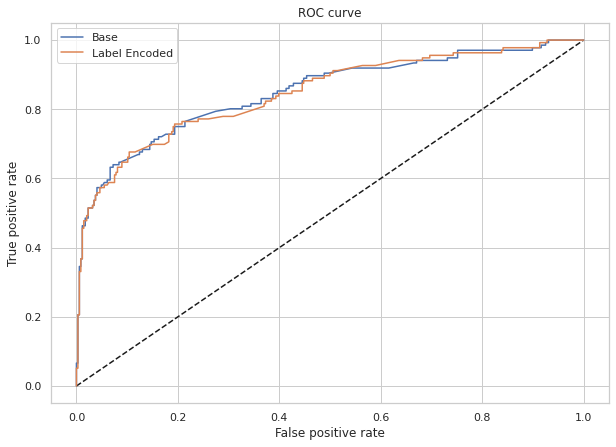

In [22]:
confusion_matrix2 = pd.crosstab(y2_test, y2_hat, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix2, annot=True, fmt = 'g', cmap = 'Reds')

print("ORIGINAL")
print(classification_report(y_test, y_hat))
print("AUC = ",roc_auc_score(y_test, y_hat),'\n\n')
print("LABEL ENCODING")
print(classification_report(y2_test, y2_hat))
print("AUC = ",roc_auc_score(y2_test, y2_hat))


y2hat_probs = LR.predict_proba(X2_test)
y2hat_probs = y2hat_probs[:, 1]

fpr2, tpr2, _ = roc_curve(y2_test, y2hat_probs)

plt.figure(figsize=(10,7))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label="Base")
plt.plot(fpr2,tpr2,label="Label Encoded")
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc="best")
plt.show()

Our recall for ICU Admission went slightly up, at the cost of some precision. AUC also increased slightly. For this model, I'd say recall takes precedence over precision, so we'll stick with this change. 

I'm curious about the ratio of ICU Admissions:Non-Admissions in the splits compared to the original column

In [23]:
print("Original 1:0 ratio =",y2.value_counts()[1]/y2.value_counts()[0])
print("Training 1:0 ratio =",y2_train.value_counts()[1]/y2_train.value_counts()[0])
print("Testing 1:0 ratio =",y2_test.value_counts()[1]/y2_test.value_counts()[0])

Original 1:0 ratio = 0.36524822695035464
Training 1:0 ratio = 0.35620300751879697
Testing 1:0 ratio = 0.3930635838150289


Looks like there are small variations in the distribution of positive:negative cases between the original data set, the training set, and the test set. We'll apply the stratity option in train_test_split in the binary target

In [24]:
X3_train,X3_test,y3_train,y3_test = train_test_split(X2,y2,test_size=0.25,random_state=42, stratify = y2, shuffle = True)

print("Original 1:0 ratio =",y2.value_counts()[1]/y2.value_counts()[0])
print("Training 1:0 ratio =",y3_train.value_counts()[1]/y3_train.value_counts()[0])
print("Testing 1:0 ratio =",y3_test.value_counts()[1]/y3_test.value_counts()[0])

Original 1:0 ratio = 0.36524822695035464
Training 1:0 ratio = 0.3651844843897824
Testing 1:0 ratio = 0.3654390934844193


Now the distributions are pretty even. Let's see the effect on our regression

In [25]:
LR.fit(X3_train,y3_train)
y3_hat = LR.predict(X3_test)

LABEL ENCODING
              precision    recall  f1-score   support

           0       0.85      0.96      0.90       346
           1       0.84      0.56      0.67       136

    accuracy                           0.84       482
   macro avg       0.84      0.76      0.78       482
weighted avg       0.84      0.84      0.83       482

AUC =  0.7577354641278476 


LABEL ENCODING + STRATIFY
              precision    recall  f1-score   support

           0       0.88      0.97      0.93       353
           1       0.89      0.65      0.75       129

    accuracy                           0.89       482
   macro avg       0.89      0.81      0.84       482
weighted avg       0.89      0.89      0.88       482

AUC =  0.8114170893998287


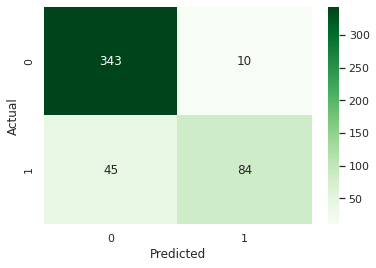

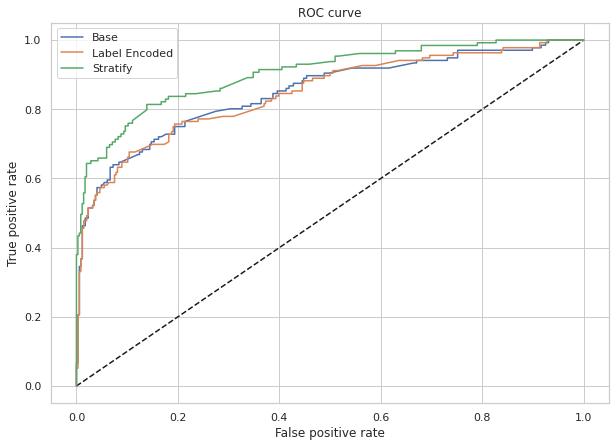

In [26]:
confusion_matrix3 = pd.crosstab(y3_test, y3_hat, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix3, annot=True, fmt = 'g', cmap = 'Greens')

print("LABEL ENCODING")
print(classification_report(y2_test, y2_hat))
print("AUC = ",roc_auc_score(y2_test, y2_hat),'\n\n')

print("LABEL ENCODING + STRATIFY")
print(classification_report(y3_test, y3_hat))
print("AUC = ",roc_auc_score(y3_test, y3_hat))

y3hat_probs = LR.predict_proba(X3_test)
y3hat_probs = y3hat_probs[:, 1]

fpr3, tpr3, _ = roc_curve(y3_test, y3hat_probs)

plt.figure(figsize=(10,7))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label="Base")
plt.plot(fpr2,tpr2,label="Label Encoded")
plt.plot(fpr3,tpr3,label="Stratify")
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc="best")
plt.show()

Yeesh, what a difference! All the metrics across the board shot up!

Now, while there may have been some improvement to the model itself, this is largely an improvement in how we evaluate the model. By stratifying, we ensure a fair test and train split.

I'm also interested in using SMOTE. SMOTE (Synthetic Minority Oversampling Technique) synthesizes instances for the minority case to create a more balanced model.

In [27]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state = 42)
X_train_res, y_train_res = sm.fit_sample(X3_train,y3_train.ravel())


LABEL ENCODING + STRATIFY
              precision    recall  f1-score   support

           0       0.88      0.97      0.93       353
           1       0.89      0.65      0.75       129

    accuracy                           0.89       482
   macro avg       0.89      0.81      0.84       482
weighted avg       0.89      0.89      0.88       482

AUC =  0.8114170893998287 


SMOTE
              precision    recall  f1-score   support

           0       0.91      0.91      0.91       353
           1       0.75      0.75      0.75       129

    accuracy                           0.87       482
   macro avg       0.83      0.83      0.83       482
weighted avg       0.87      0.87      0.87       482

AUC =  0.829226782616334


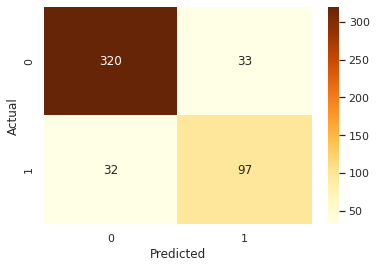

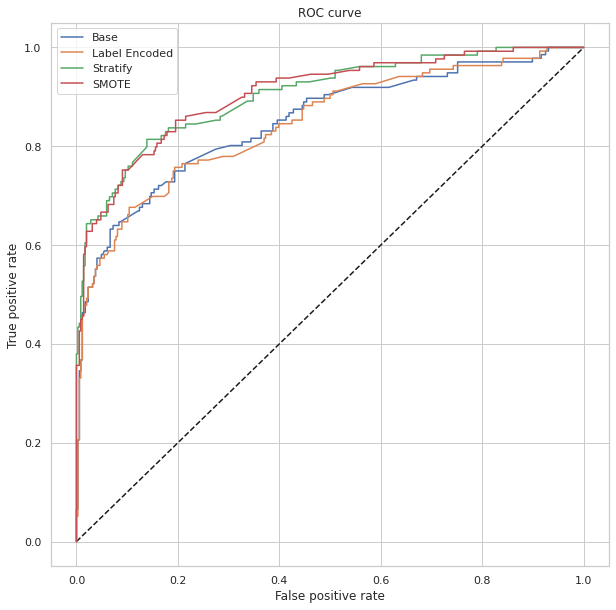

In [28]:
LR.fit(X_train_res, y_train_res)
y_res_hat = LR.predict(X3_test)

confusion_matrix3 = pd.crosstab(y3_test, y_res_hat, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix3, annot=True, fmt = 'g', cmap="YlOrBr")

print("LABEL ENCODING + STRATIFY")
print(classification_report(y3_test, y3_hat))
print("AUC = ",roc_auc_score(y3_test, y3_hat),'\n\n')

print("SMOTE")
print(classification_report(y3_test, y_res_hat))
print("AUC = ",roc_auc_score(y3_test, y_res_hat))

y_res_hat_probs = LR.predict_proba(X3_test)
y_res_hat_probs = y_res_hat_probs[:, 1]

fpr_res, tpr_res, _ = roc_curve(y3_test, y_res_hat_probs)

plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label="Base")
plt.plot(fpr2,tpr2,label="Label Encoded")
plt.plot(fpr3,tpr3,label="Stratify")
plt.plot(fpr_res,tpr_res,label="SMOTE")
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc="best")
plt.show()

Positive ICU admission recall jumps significantly, and the AUC increases as well. The precision of the positive case drops significantly, so the positive F1 Score stays about the same. Overall accuracy also drops slightly.

Let's do some final visualizations for the two best approaches, the Label Encoded + Stratified model, and the same model but with SMOTE.

P-R AUC: 0.8451719514274245
P-R AUC (SMOTE): 0.8422423223672759


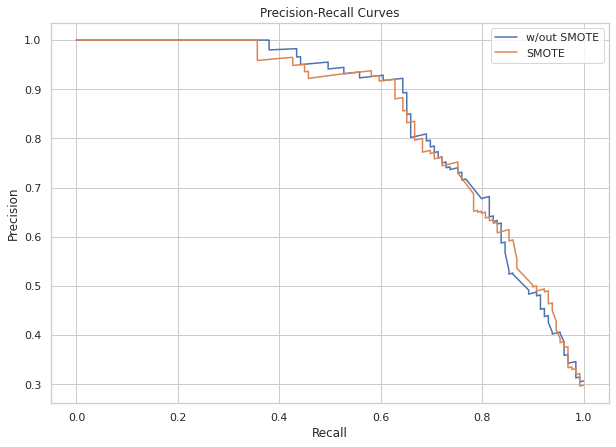

In [29]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import plot_precision_recall_curve

precision, recall, _ = precision_recall_curve(y3_test, y3hat_probs)
precision_sm, recall_sm, _ = precision_recall_curve(y3_test, y_res_hat_probs)

plt.figure(figsize=(10,7))
plt.plot(recall, precision, label="w/out SMOTE")
plt.plot(recall_sm, precision_sm, label="SMOTE")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves")
plt.legend(loc="best")

auc_score = auc(recall, precision)
auc_score_sm = auc(recall_sm, precision_sm)

print("P-R AUC:", auc_score)
print("P-R AUC (SMOTE):", auc_score_sm)

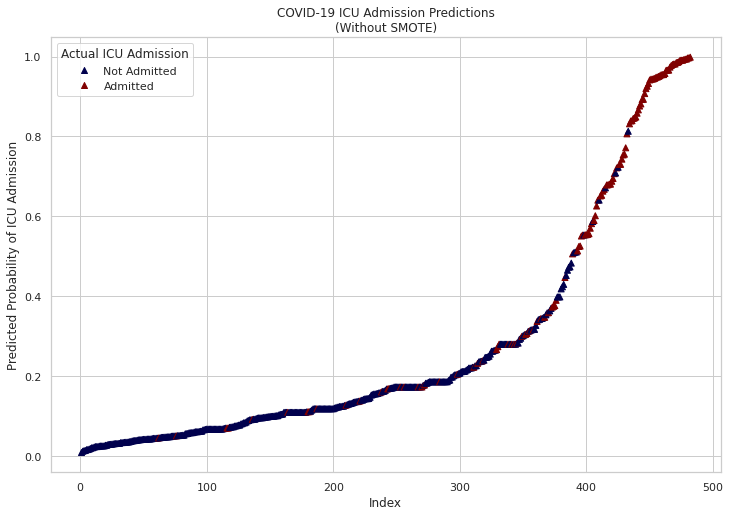

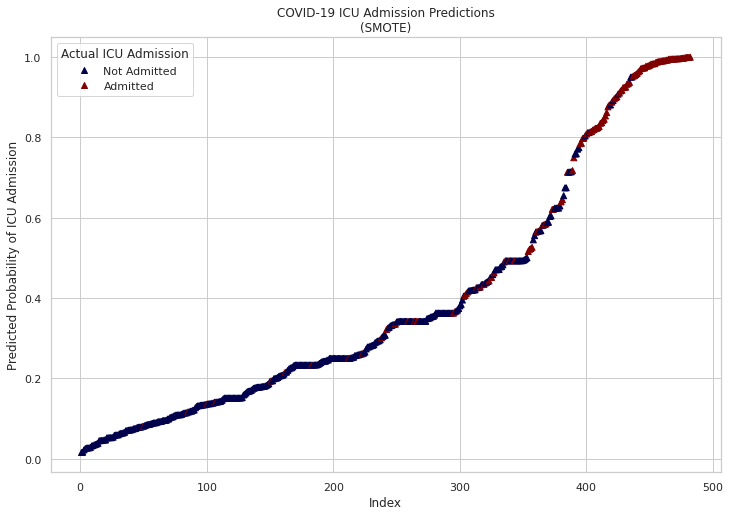

In [30]:
#y3hat_probs
#y_res_hat_probs
import matplotlib.patches as mpatches
y3 = np.asarray(y3_test)

predict_df = pd.DataFrame({'Probability of Admission':y3hat_probs, 'Admission':y3})
predict_df = predict_df.sort_values('Probability of Admission')

predict_df['Rank'] = np.arange(1,483)

plt.figure(figsize=(12,8))

classes = ['Not Admitted','Admitted']
scatter = plt.scatter(predict_df['Rank'],predict_df['Probability of Admission'],
                      c=predict_df['Admission'], 
                      cmap = 'seismic', 
                      marker = '^')
plt.title("COVID-19 ICU Admission Predictions\n(Without SMOTE)")
plt.xlabel("Index")
plt.ylabel("Predicted Probability of ICU Admission")
plt.legend(handles=scatter.legend_elements()[0], labels=classes,title="Actual ICU Admission", loc='best')
plt.show()


predict_df2= pd.DataFrame({'SMOTE_prob':y_res_hat_probs, 'Admission':y3})
predict_df2 = predict_df2.sort_values("SMOTE_prob")
predict_df2['Rank'] = np.arange(1,483)

plt.figure(figsize=(12,8))

scatter = plt.scatter(predict_df2['Rank'],predict_df2['SMOTE_prob'],
                      c=predict_df2['Admission'], 
                      cmap = 'seismic', 
                      marker = '^')
plt.title("COVID-19 ICU Admission Predictions\n(SMOTE)")
plt.xlabel("Index")
plt.ylabel("Predicted Probability of ICU Admission")
plt.legend(handles=scatter.legend_elements()[0], labels=classes,title="Actual ICU Admission", loc='best')
plt.show()





In both models, we see that at very low and very high probabilities the real life results almost always correspond to the prediction. 

# Conclusion?

So we ultimately end up with two models. One without synthesized cases, which has a higher positive precision and overall accuracy, and one with synthesized cases for training, which suffers in positive precision and overall accuracy but has a greater positive recall. In any case, the probability generated by the logistic regression model must always be considered for a given prediction.

For the main purpose of the model, that is, predicting patient ICU admission, it may be safer to go with higher recall, due to the lower number of False Negatives. However, higher precision may actually be desirable. As I said in the beginning, we are not diagnosing illness, but determining if a person is likely to need an ICU bed. False Positives may lead to beds being occupied unnecessarily. If beds are extremely limited (which they are increasingly becoming), this would not ideal. 

So thus we are left with difficult questions: do we help as many people that need it as possible, with the risk of occupying beds unnecessarily? Or do we allocate ICU beds as efficiently as possible, with a greater risk of someone that needs a bed not getting one? Of course, this is for decisions made by a mathematical model. The final decisions ultimately lie with health care professionals, who will probably know better than a Logistic Regression algorithim implemented by someone who knows little about medicine. The insights may be useful, nonetheless.

I don't feel particularly done here. I want to improve feature selection for starters, something a bit better than looking for linear correlations. I have seen some of my colleagues on Kaggle use libraries like xgboost for this purpose, so I may explore that. I mentioned earlier that I'm also not satisfied with our solution to missing data. I realize there's no perfect solution to accounting for missing information, but I would like to explore other possible strategies. I also would like to look into other classification models, e.g. Random Forest.

But as it stands, I'd say we have a halfway decent model to start from.